In [60]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import os
import glob
import regionmask
import xarray as xr
import numpy as np

Calling the two datasets (ERA5 and the Borough Boundaries across Alaska)

In [61]:
shapefile_path = "/center1/DYNDOWN/phutton5/ROS/boundaries/Alaska_Borough_and_Census_Area_Boundaries.shp"
borough_boundaries = gpd.read_file(shapefile_path)
borough_boundaries = borough_boundaries.set_crs(epsg=3338)
borough_boundaries = borough_boundaries.to_crs(epsg=4326)
FNSB_boundary = borough_boundaries[borough_boundaries['CommunityN'] == 'Fairbanks North Star Borough']
FNSB_geom = FNSB_boundary.geometry.iloc[0] 
FNSB_coords = []
FNSB_coords.extend(list(FNSB_geom.exterior.coords))
FNSB_coords = np.array(FNSB_coords)  
FNSB_coords = pd.DataFrame({
    "lon": FNSB_coords[:, 0],
    "lat": FNSB_coords[:, 1]
})

In [62]:
path='/import/beegfs/CMIP6/wrf_era5/04km'
year='2021'
month='12'

folder = os.path.join(path, year)
pattern = f"era5_wrf_dscale_4km_{year}-{month}-*.nc"
file_list = sorted(glob.glob(os.path.join(folder, pattern)))
data = xr.open_mfdataset(file_list, combine='by_coords')
lat=data['XLAT']
lon=data['XLONG']

Masking the two datasets

In [63]:
def borough_land_mask(shapefile,data,lat,lon):
    mask = regionmask.mask_geopandas(shapefile, lon, lat)
    data_masked = data.where(~np.isnan(mask))
    
    os.chdir("/import/beegfs/CMIP6/wrf_era5")
    geo_em_path = "geo_em.d02.nc"
    geo = xr.open_dataset(geo_em_path)
    landmask = geo['LANDMASK']
    landmask=landmask.squeeze(dim="Time")
    landmask_expanded = landmask.expand_dims(Time=data_masked_FNSB.Time)

    data_fixed = data_masked.where(landmask_expanded== 1)
    data_fixed = data_fixed.chunk(dict(south_north=-1, west_east=-1))
    data_filled = data_fixed.interpolate_na(dim="south_north", method="nearest", fill_value="extrapolate")
    data_filled = data_filled.interpolate_na(dim="west_east", method="nearest", fill_value="extrapolate")
    data_final = data_filled.where(~np.isnan(mask))
    return data_final


In [76]:
FNSB_data=borough_land_mask(FNSB_boundary,data,lat,lon)

FNSB_T2=FNSB_data['T2']
FNSB_SNOW=FNSB_data['SNOW']
FNSB_ACSNOW=FNSB_data['acsnow']
FNSB_RAINC=FNSB_data['rainc'] #convective 
FNSB_RAINNC=FNSB_data['rainnc']
FNSB_RAIN=FNSB_RAINNC-FNSB_ACSNOW

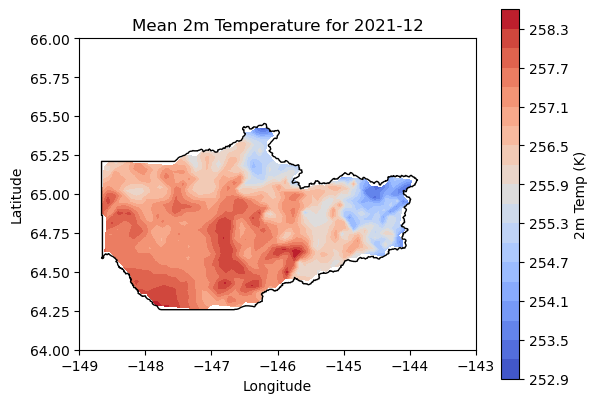

In [78]:
fig, ax = plt.subplots()  
cf = ax.contourf(lon, lat, np.mean(FNSB_T2, axis=0), levels=20, cmap='coolwarm')
cbar = fig.colorbar(cf, ax=ax, label='2m Temp (K)')
FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, zorder=2)  
ax.set_title(f"Mean 2m Temperature for {year}-{month}")
ax.set_xlim(-149, -143)
ax.set_ylim(64, 66)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

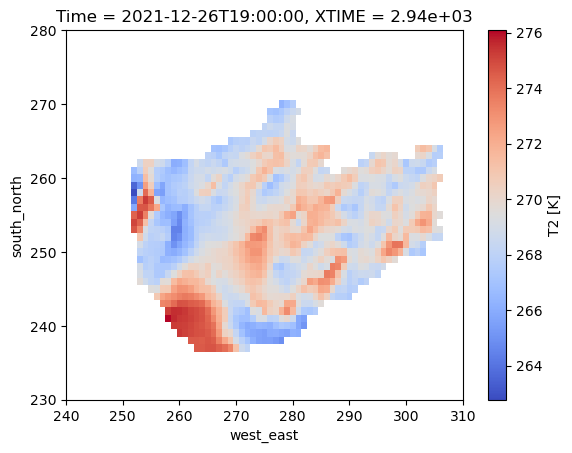

In [79]:
FNSB_T2.isel(Time=619).plot( cmap='coolwarm')
plt.xlim(240, 310)
plt.ylim(230, 280)
plt.show()

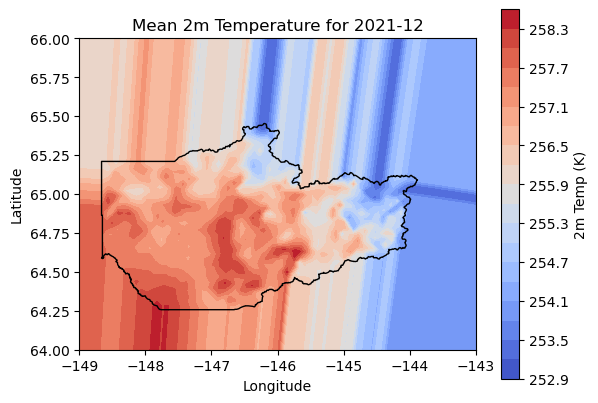

: 

In [ ]:
fig, ax = plt.subplots()  
cf = ax.contourf(lon, lat, np.mean(T2_masked_lakes, axis=0), levels=20, cmap='coolwarm')
cbar = fig.colorbar(cf, ax=ax, label='2m Temp (K)')
FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, zorder=2)  
ax.set_title(f"Mean 2m Temperature for {year}-{month}")
ax.set_xlim(-149, -143)
ax.set_ylim(64, 66)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

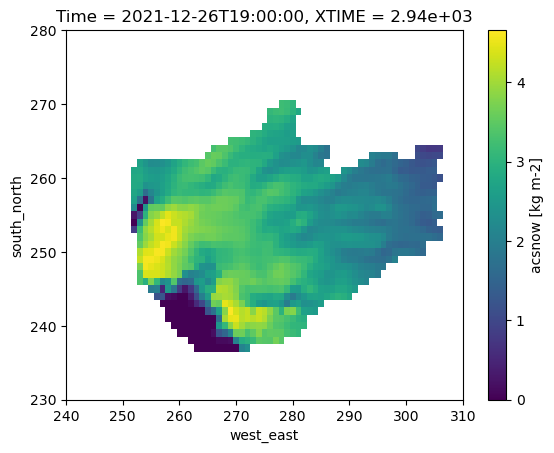

In [82]:
FNSB_ACSNOW.isel(Time=619).plot()
plt.xlim(240, 310)
plt.ylim(230, 280)
plt.show()

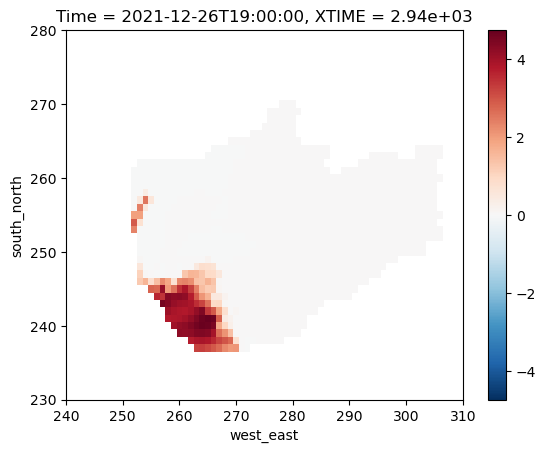

In [72]:
FNSB_RAIN.isel(Time=619).plot()
plt.xlim(240, 310)
plt.ylim(230, 280)
plt.show()

In [75]:
'''
#Raw script before making it into the function above
mask = regionmask.mask_geopandas(FNSB_boundary, lon, lat)
data_masked = data.where(~np.isnan(mask))

os.chdir("/import/beegfs/CMIP6/wrf_era5")
geo_em_path = "geo_em.d02.nc"
geo = xr.open_dataset(geo_em_path)
landmask = geo['LANDMASK']
landmask=landmask.squeeze(dim="Time")
landmask_expanded = landmask.expand_dims(Time=data_masked_FNSB.Time)

data_fixed = data_masked.where(landmask_expanded== 1)
data_fixed = data_fixed.chunk(dict(south_north=-1, west_east=-1))
data_filled = data_fixed.interpolate_na(dim="south_north", method="nearest", fill_value="extrapolate")
data_filled = data_filled.interpolate_na(dim="west_east", method="nearest", fill_value="extrapolate")

#Same mask as before--do this so it removed the outside boundary again (mask = regionmask.mask_geopandas(FNSB_boundary, lon, lat))
data_filled = data_filled.where(~np.isnan(mask))
'''

'\n#Raw script before making it into the function above\nmask = regionmask.mask_geopandas(FNSB_boundary, lon, lat)\ndata_masked = data.where(~np.isnan(mask))\n\nos.chdir("/import/beegfs/CMIP6/wrf_era5")\ngeo_em_path = "geo_em.d02.nc"\ngeo = xr.open_dataset(geo_em_path)\nlandmask = geo[\'LANDMASK\']\nlandmask=landmask.squeeze(dim="Time")\nlandmask_expanded = landmask.expand_dims(Time=data_masked_FNSB.Time)\n\ndata_fixed = data_masked.where(landmask_expanded== 1)\ndata_fixed = data_fixed.chunk(dict(south_north=-1, west_east=-1))\ndata_filled = data_fixed.interpolate_na(dim="south_north", method="nearest", fill_value="extrapolate")\ndata_filled = data_filled.interpolate_na(dim="west_east", method="nearest", fill_value="extrapolate")\n\n#Same mask as before--do this so it removed the outside boundary again (mask = regionmask.mask_geopandas(FNSB_boundary, lon, lat))\ndata_filled = data_filled.where(~np.isnan(mask))\n'

In [83]:
FNSB_ros_events=(FNSB_T2 >273) & (FNSB_RAIN > 2.54 ) & (FNSB_SNOW > 25.4) 
#Temberature  greater than 273 K 
#Total rainfall of at least 2.54 mm (0.1in)
#Snow depth exceeds 25.4 mm (1 in.) -- need to make sure this is at 
    #   both the start and end of the event.’ 
#Criteria from both Crawford et al 2020 and Bieniek et al 2018

FNSB_ros_tally = FNSB_ros_events.sum(dim='Time') 
#per hour, so max of 50 is how many hours that thisoccured during this period

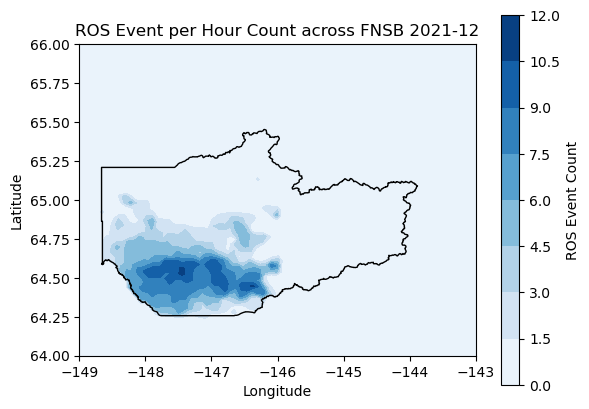

: 

In [ ]:
fig, ax = plt.subplots()  
cf = ax.contourf(lon, lat, FNSB_ros_tally,cmap='Blues')
cbar = fig.colorbar(cf, ax=ax, label='ROS Event Count')
FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, zorder=2)  
ax.set_title(f"ROS Event per Hour Count across FNSB {year}-{month}")
ax.set_xlim(-149, -143)
ax.set_ylim(64, 66)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()